In [1]:
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import ezc3d
import os

from Functions import Joint_Angle

In [12]:
file_list = [i.replace('\\','/') for i in sorted(glob('Data/vicon_c3d/**/*c3d'))]
file_name = [os.path.basename(i).replace('.c3d','') for i in file_list]
AB_list = [i for i in file_list if "AB" in i]
AB_name = [os.path.basename(i).replace('.c3d','') for i in AB_list]
FL_list = [i for i in file_list if "FL" in i]
FL_name = [os.path.basename(i).replace('.c3d','') for i in FL_list]
YB_list = [i for i in file_list if "Y-BAL" in i]
YB_name = [os.path.basename(i).replace('.c3d','') for i in YB_list]
Other_list = [i for i in file_list if ("HAD" in i)|("IRER" in i)]
Other_name = [os.path.basename(i).replace('.c3d','') for i in Other_list]

### Create Local Coordinate

In [14]:
def R_UpperArm(RSHO, RUPA, RELB, RSJC, REJC):
    origin = RSJC
    z = RSJC - REJC
    x_temp = RELB - REJC
    y = np.cross(z, x_temp)
    x = np.cross(y, z)
    
    x_norm = x/np.linalg.norm(x)
    y_norm = y/np.linalg.norm(y)
    z_norm = z/np.linalg.norm(z)
    
    R = np.transpose(np.array([x_norm,y_norm,z_norm]))
    T = np.array([[R[0,0],R[0,1],R[0,2],origin[0]],
                  [R[1,0],R[1,1],R[1,2],origin[1]],
                  [R[2,0],R[2,1],R[2,2],origin[2]],
                  [0     ,0     ,0     ,1    ]])
    return T

def Trunk(C7, T10, CLAV, STRN):
    origin = (C7 + CLAV)/2
    prox = (T10 + STRN) / 2
    z = origin - prox
    y_temp = CLAV - C7
    x = np.cross(z, y_temp)
    y = np.cross(z, x)
    
    x_norm = x/np.linalg.norm(x)
    y_norm = y/np.linalg.norm(y)
    z_norm = z/np.linalg.norm(z)
    
    R = np.transpose(np.array([x_norm,y_norm,z_norm]))
    T = np.array([[R[0,0],R[0,1],R[0,2],origin[0]],
                  [R[1,0],R[1,1],R[1,2],origin[1]],
                  [R[2,0],R[2,1],R[2,2],origin[2]],
                  [0     ,0     ,0     ,1    ]])
    return T

### Calculate Shoulder Abduction

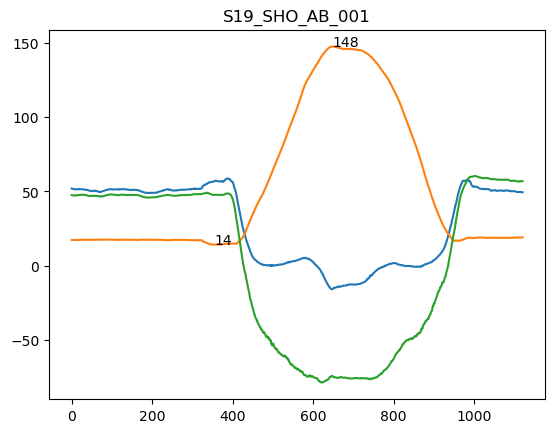

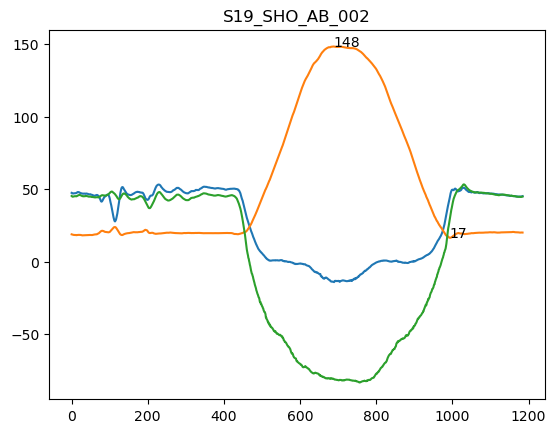

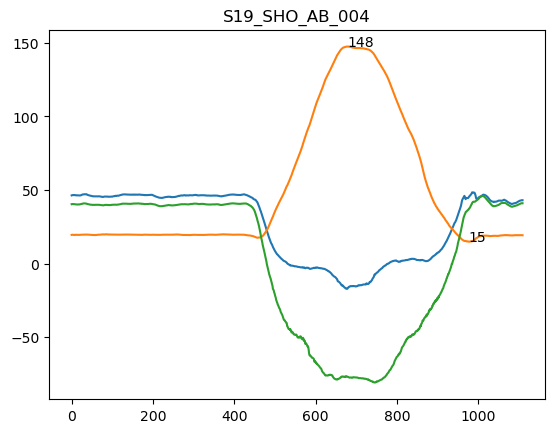

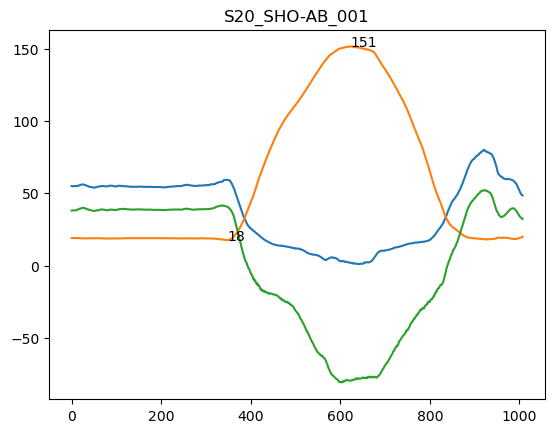

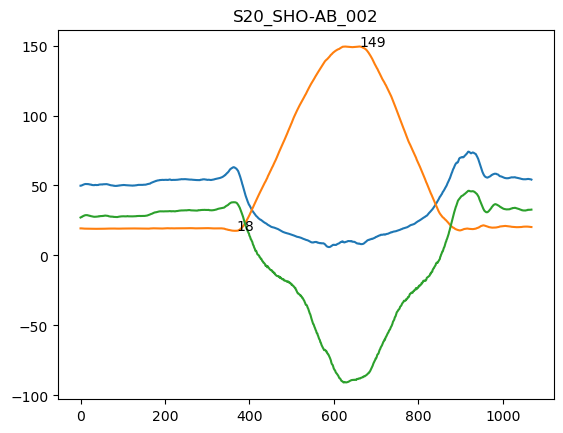

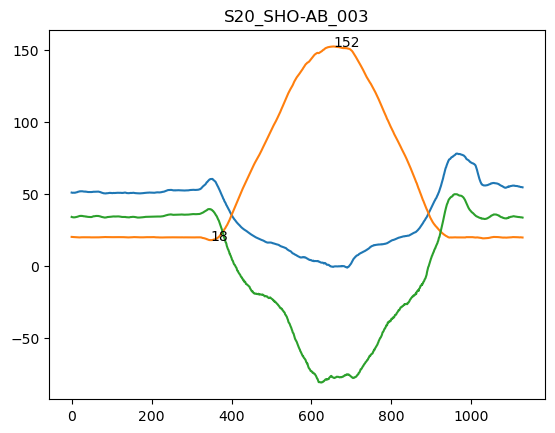

In [15]:
wrong = []
AB = {}
for file, name in zip(AB_list, AB_name):
    c3d = ezc3d.c3d(file,extract_forceplat_data=True)
    markers = {}
    N = len(c3d['parameters']['POINT']['LABELS']['value'])

    for i in range(N):
        markers[c3d['parameters']['POINT']['LABELS']['value'][i]] = c3d['data']['points'][:3,i,:]

    N = markers['RELB'].shape[-1]
    r_upper_R = np.zeros((4,4,N))
    trunk_R = np.zeros((4,4,N))
    
    
    try:
        for i in range(N):
            r_upper_R[:,:,i] = R_UpperArm(markers['RSHO'][:,i],markers['RUPA'][:,i],markers['RELB'][:,i],markers['RSJC'][:,i],markers['REJC'][:,i])
            trunk_R[:,:,i] = Trunk(markers['C7'][:,i],markers['T10'][:,i],markers['CLAV'][:,i],markers['STRN'][:,i])
        
        Reference_trunk_R = Joint_Angle.Calculate_Reference_Frame(trunk_R, trunk_R[:,:,1])
        Reference_upper_R = Joint_Angle.Calculate_Reference_Frame(r_upper_R, r_upper_R[:,:,1])
    

        
        shoulder_angle = Joint_Angle.joint_angle(trunk_R, r_upper_R, 'RT_SHOULDER', 'zyz')
        for col in shoulder_angle.columns:
            shoulder_angle[col] = Joint_Angle.process_angle(shoulder_angle[col])
        

        # shoulder_angle['RT_SHOULDER_ANGLE_X'] = shoulder_angle['RT_SHOULDER_ANGLE_X'] - shoulder_angle['RT_SHOULDER_ANGLE_X'][0]
        # # shoulder_angle['RT_SHOULDER_ANGLE_Y'] = shoulder_angle['RT_SHOULDER_ANGLE_Y'] - shoulder_angle['RT_SHOULDER_ANGLE_Y'][0]    
        # shoulder_angle['RT_SHOULDER_ANGLE_Z'] = shoulder_angle['RT_SHOULDER_ANGLE_Z'] - shoulder_angle['RT_SHOULDER_ANGLE_Z'][0]
        
        # shoulder_angle['RT_SHOULDER_ANGLE_Y'] = - shoulder_angle['RT_SHOULDER_ANGLE_Y']
        shoulder_angle['RT_SHOULDER_ANGLE_X'] = - shoulder_angle['RT_SHOULDER_ANGLE_X']
        shoulder_angle['RT_SHOULDER_ANGLE_Z'] = shoulder_angle['RT_SHOULDER_ANGLE_Z'] - shoulder_angle['RT_SHOULDER_ANGLE_Z'].mean()
        # # shoulder_angle['RT_SHOULDER_ANGLE_X'] = shoulder_angle['RT_SHOULDER_ANGLE_X'] + x_off
        # shoulder_angle['RT_SHOULDER_ANGLE_Y'] = shoulder_angle['RT_SHOULDER_ANGLE_Y'] + y_off
        
        plt.plot(shoulder_angle)
        plt.text(np.where(shoulder_angle['RT_SHOULDER_ANGLE_Y'] == shoulder_angle['RT_SHOULDER_ANGLE_Y'].max())[0][0], shoulder_angle['RT_SHOULDER_ANGLE_Y'].max(), round(shoulder_angle['RT_SHOULDER_ANGLE_Y'].max()))
        plt.text(np.where(shoulder_angle['RT_SHOULDER_ANGLE_Y'] == shoulder_angle['RT_SHOULDER_ANGLE_Y'].min())[0][0], shoulder_angle['RT_SHOULDER_ANGLE_Y'].min(), round(shoulder_angle['RT_SHOULDER_ANGLE_Y'].min()))


        plt.title(name)
        # plt.legend()
        plt.show()
        
        AB[name] = shoulder_angle
    except Exception as e:
        print(file, ":", e)
        wrong.append(file)

### Calculate Shoulder Flexion

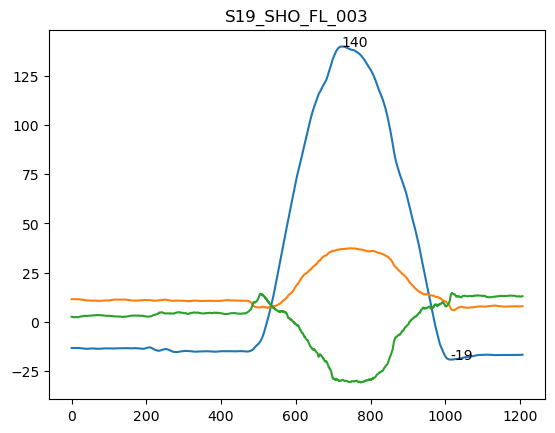

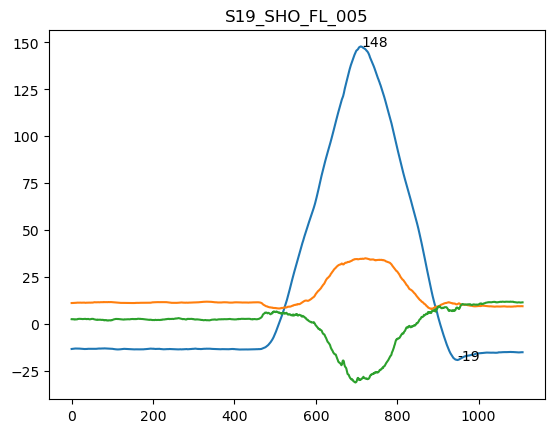

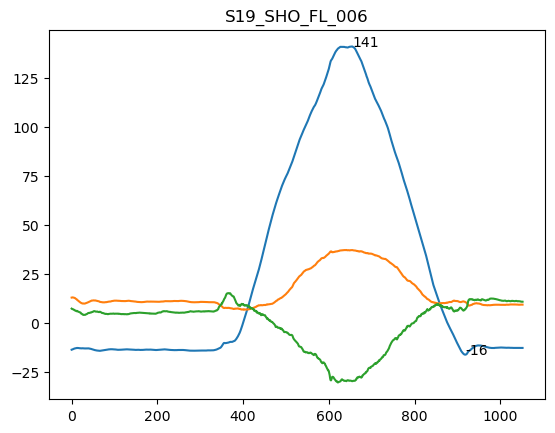

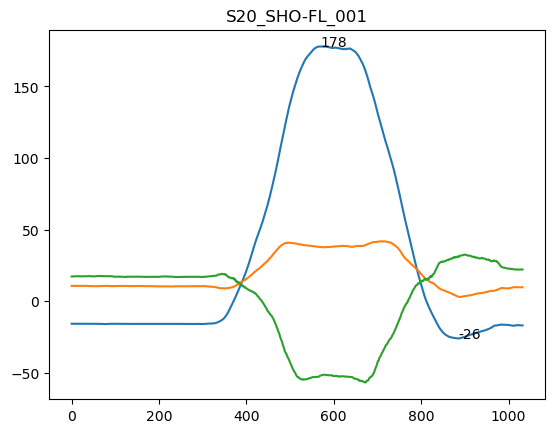

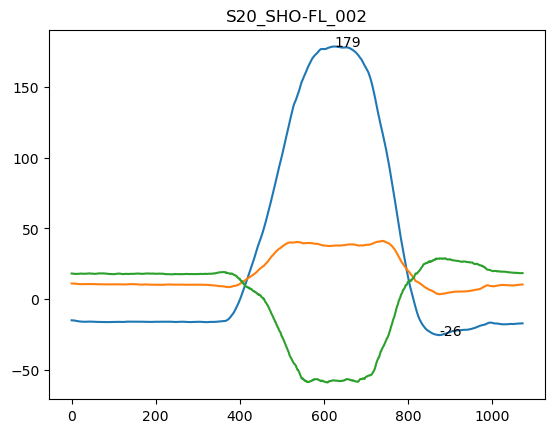

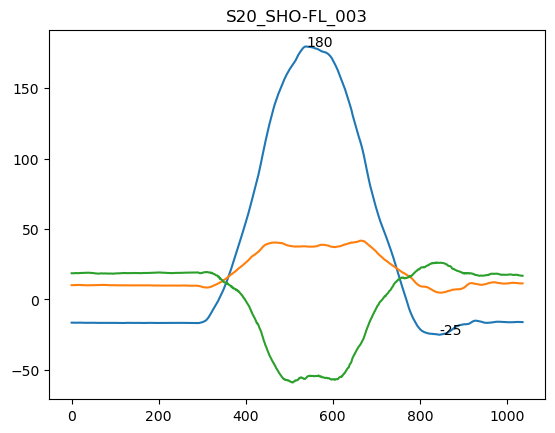

In [16]:
wrong = []
FL = {}
for file, name in zip(FL_list, FL_name):
    c3d = ezc3d.c3d(file,extract_forceplat_data=True)
    markers = {}
    N = len(c3d['parameters']['POINT']['LABELS']['value'])

    for i in range(N):
        markers[c3d['parameters']['POINT']['LABELS']['value'][i]] = c3d['data']['points'][:3,i,:]

    N = markers['RELB'].shape[-1]
    r_upper_R = np.zeros((4,4,N))
    trunk_R = np.zeros((4,4,N))
    
    
    try:
        for i in range(N):
            r_upper_R[:,:,i] = R_UpperArm(markers['RSHO'][:,i],markers['RUPA'][:,i],markers['RELB'][:,i],markers['RSJC'][:,i],markers['REJC'][:,i])
            trunk_R[:,:,i] = Trunk(markers['C7'][:,i],markers['T10'][:,i],markers['CLAV'][:,i],markers['STRN'][:,i])
            
        Reference_upperr_R = Joint_Angle.Calculate_Reference_Frame(r_upper_R, r_upper_R[:,:,1])
        Reference_trunk_R = Joint_Angle.Calculate_Reference_Frame(trunk_R, trunk_R[:,:,1])
        
        re_angle = Joint_Angle.global_angle(r_upper_R, 'RT_SHOULDER','xyz')
        for col in re_angle.columns:
            re_angle[col] = Joint_Angle.process_angle(re_angle[col])
        
        x_off, y_off, z_off = re_angle.iloc[0:20].mean()

        shoulder_angle = Joint_Angle.joint_angle(trunk_R, r_upper_R, 'RT_SHOULDER', 'xyz')
        
        for col in shoulder_angle.columns:
            shoulder_angle[col] = Joint_Angle.process_angle(shoulder_angle[col])
            
        # shoulder_angle['RT_SHOULDER_ANGLE_Z'] = shoulder_angle['RT_SHOULDER_ANGLE_Z'] - shoulder_angle['RT_SHOULDER_ANGLE_Z'].iloc[0:20].mean()
        # shoulder_angle['RT_SHOULDER_ANGLE_Y'] = shoulder_angle['RT_SHOULDER_ANGLE_Y'] - shoulder_angle['RT_SHOULDER_ANGLE_Y'].iloc[0:20].mean()
        # shoulder_angle['RT_SHOULDER_ANGLE_X'] = shoulder_angle['RT_SHOULDER_ANGLE_X'] - shoulder_angle['RT_SHOULDER_ANGLE_X'].iloc[0:20].mean()
        shoulder_angle[['RT_SHOULDER_ANGLE_X','RT_SHOULDER_ANGLE_Z']] = - shoulder_angle[['RT_SHOULDER_ANGLE_X','RT_SHOULDER_ANGLE_Z']]
        shoulder_angle['RT_SHOULDER_ANGLE_Z'] = shoulder_angle['RT_SHOULDER_ANGLE_Z'] - shoulder_angle['RT_SHOULDER_ANGLE_Z'].mean()
        plt.plot(shoulder_angle)
        plt.text(np.where(shoulder_angle['RT_SHOULDER_ANGLE_X'] == shoulder_angle['RT_SHOULDER_ANGLE_X'].max())[0][0], shoulder_angle['RT_SHOULDER_ANGLE_X'].max(), round(shoulder_angle['RT_SHOULDER_ANGLE_X'].max()))
        plt.text(np.where(shoulder_angle['RT_SHOULDER_ANGLE_X'] == shoulder_angle['RT_SHOULDER_ANGLE_X'].min())[0][0], shoulder_angle['RT_SHOULDER_ANGLE_X'].min(), round(shoulder_angle['RT_SHOULDER_ANGLE_X'].min()))
        plt.title(name)
        plt.show()
        
        FL[name] = shoulder_angle
        
    except Exception as e:
        print(file, ":", e)
        wrong.append(file)

### Shoulder Internal Rotation, Horizontal Adduction

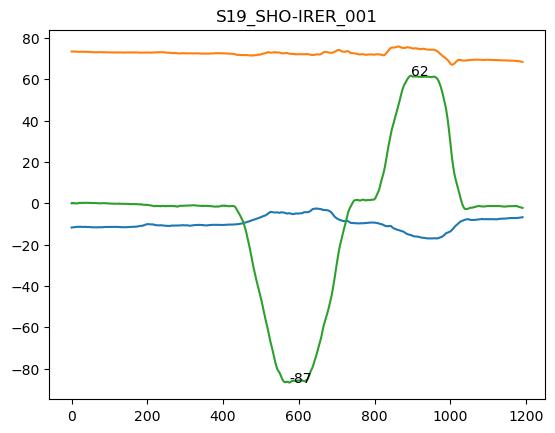

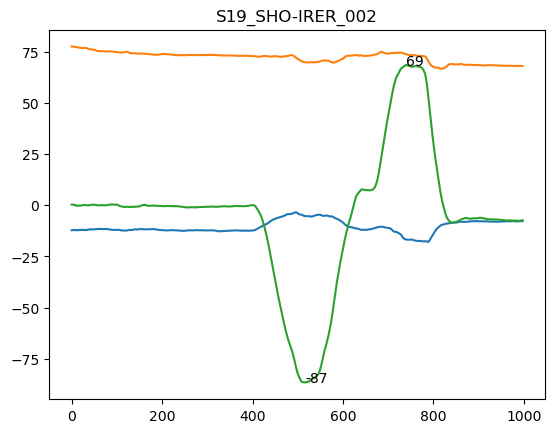

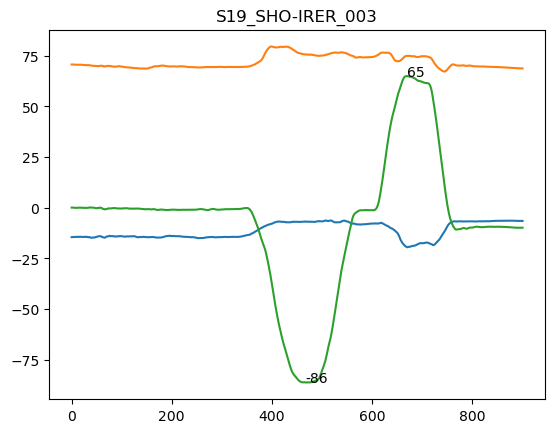

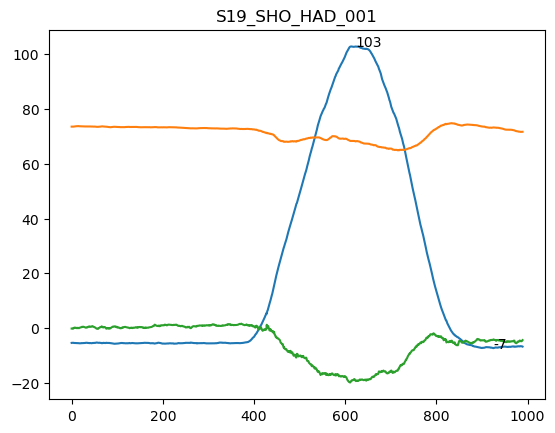

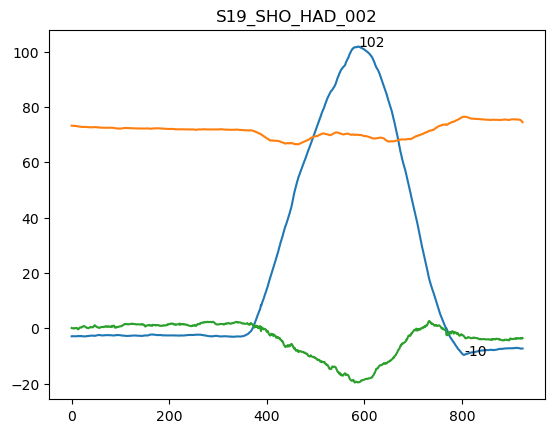

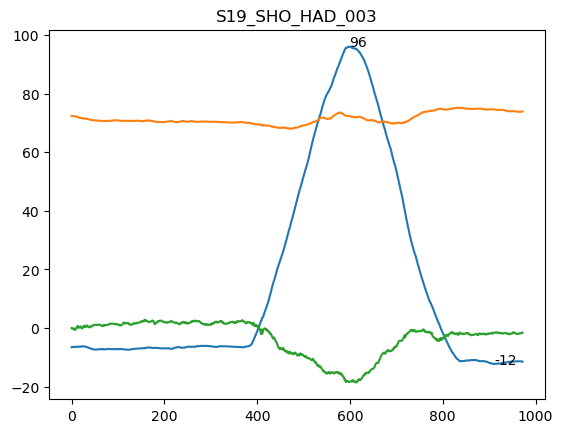

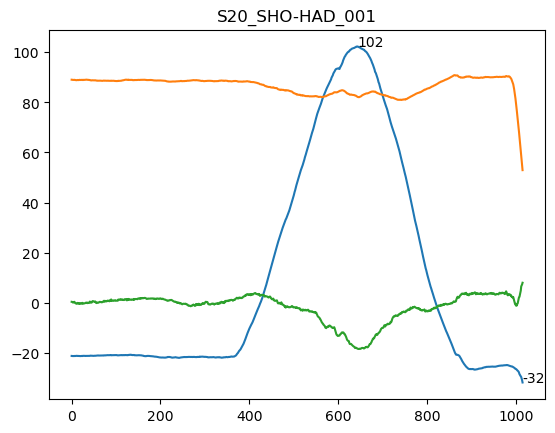

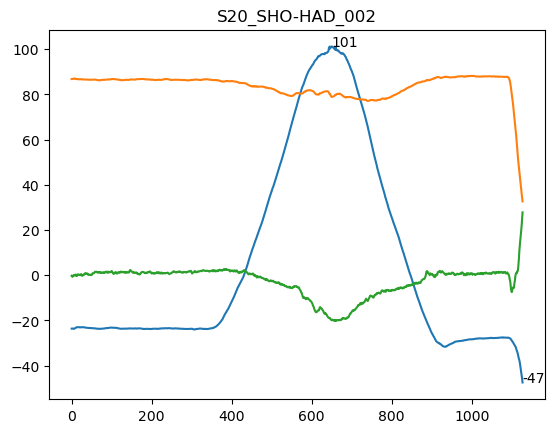

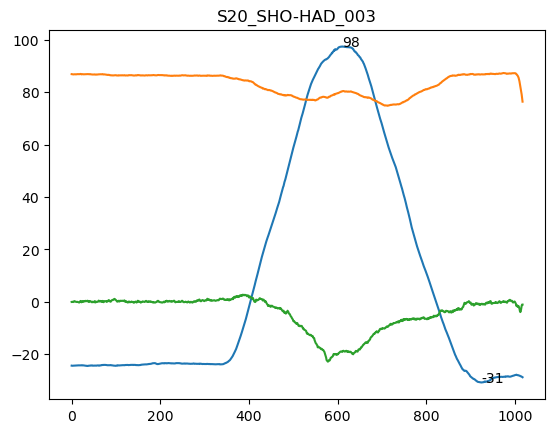

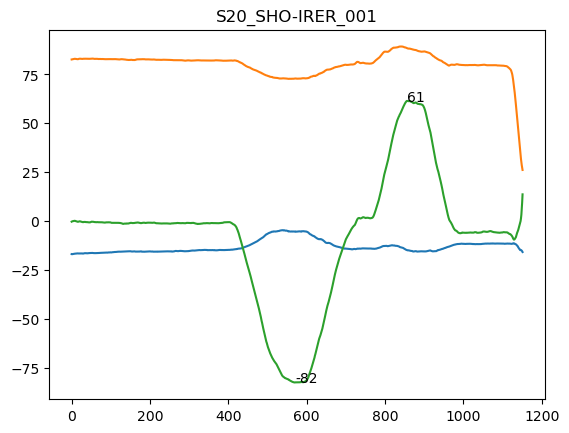

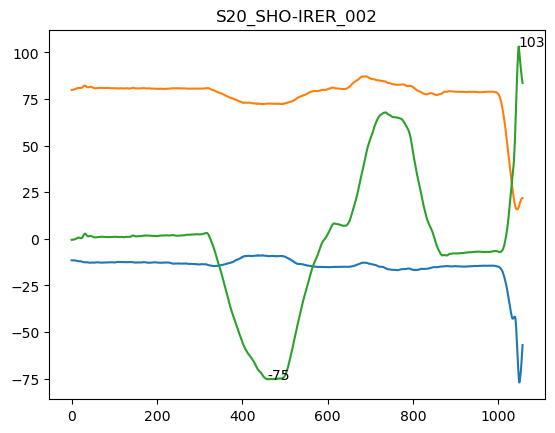

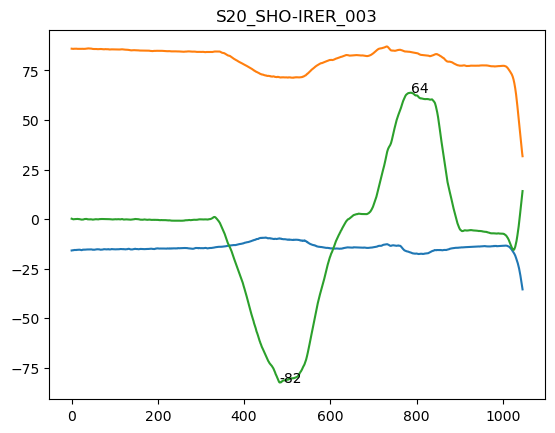

In [17]:
wrong = []
HAD_IRER = {}
for file, name in zip(Other_list, Other_name):
    c3d = ezc3d.c3d(file,extract_forceplat_data=True)
    markers = {}
    N = len(c3d['parameters']['POINT']['LABELS']['value'])

    for i in range(N):
        markers[c3d['parameters']['POINT']['LABELS']['value'][i]] = c3d['data']['points'][:3,i,:]

    N = markers['RELB'].shape[-1]
    r_upper_R = np.zeros((4,4,N))
    trunk_R = np.zeros((4,4,N))
    
    
    try:
        for i in range(N):
            r_upper_R[:,:,i] = R_UpperArm(markers['RSHO'][:,i],markers['RUPA'][:,i],markers['RELB'][:,i],markers['RSJC'][:,i],markers['REJC'][:,i])
            trunk_R[:,:,i] = Trunk(markers['C7'][:,i],markers['T10'][:,i],markers['CLAV'][:,i],markers['STRN'][:,i])
            
        Reference_upperr_R = Joint_Angle.Calculate_Reference_Frame(r_upper_R, r_upper_R[:,:,1])
        Reference_trunk_R = Joint_Angle.Calculate_Reference_Frame(trunk_R, trunk_R[:,:,1])
        
        shoulder_angle = Joint_Angle.joint_angle(trunk_R, r_upper_R, 'RT_SHOULDER', 'zyz')
        
        for col in shoulder_angle.columns:
            shoulder_angle[col] = Joint_Angle.process_angle(shoulder_angle[col])
            
        shoulder_angle['RT_SHOULDER_ANGLE_Z'] = shoulder_angle['RT_SHOULDER_ANGLE_Z'] - shoulder_angle['RT_SHOULDER_ANGLE_Z'].iloc[0:20].mean()
        # shoulder_angle['RT_SHOULDER_ANGLE_Y'] = shoulder_angle['RT_SHOULDER_ANGLE_Y'] - shoulder_angle['RT_SHOULDER_ANGLE_Y'][0]
        shoulder_angle['RT_SHOULDER_ANGLE_X'] = shoulder_angle['RT_SHOULDER_ANGLE_X']
        # shoulder_angle[['RT_SHOULDER_ANGLE_X']] = - shoulder_angle[['RT_SHOULDER_ANGLE_X']]
        
        plt.plot(shoulder_angle)
        if 'HAD' in file:
            plt.text(np.where(shoulder_angle['RT_SHOULDER_ANGLE_X'] == shoulder_angle['RT_SHOULDER_ANGLE_X'].max())[0][0], shoulder_angle['RT_SHOULDER_ANGLE_X'].max(), round(shoulder_angle['RT_SHOULDER_ANGLE_X'].max()))
            plt.text(np.where(shoulder_angle['RT_SHOULDER_ANGLE_X'] == shoulder_angle['RT_SHOULDER_ANGLE_X'].min())[0][0], shoulder_angle['RT_SHOULDER_ANGLE_X'].min(), round(shoulder_angle['RT_SHOULDER_ANGLE_X'].min()))
        if 'IRER' in file:
            plt.text(np.where(shoulder_angle['RT_SHOULDER_ANGLE_Z'] == shoulder_angle['RT_SHOULDER_ANGLE_Z'].max())[0][0], shoulder_angle['RT_SHOULDER_ANGLE_Z'].max(), round(shoulder_angle['RT_SHOULDER_ANGLE_Z'].max()))
            plt.text(np.where(shoulder_angle['RT_SHOULDER_ANGLE_Z'] == shoulder_angle['RT_SHOULDER_ANGLE_Z'].min())[0][0], shoulder_angle['RT_SHOULDER_ANGLE_Z'].min(), round(shoulder_angle['RT_SHOULDER_ANGLE_Z'].min()))
        plt.title(name)
        plt.show()
        
        HAD_IRER[name] = shoulder_angle
        
    except Exception as e:
        print(file, ":", e)
        wrong.append(file)

In [18]:
storeDir = "ExpData/VICON_FINAL"
os.makedirs(storeDir, exist_ok=True)
for ab in AB:
    sub = ab.split("_")[0]
    os.makedirs(f"{storeDir}/{sub}", exist_ok=True)
    AB[ab].to_csv(f"{storeDir}/{sub}/{ab}.csv",index=False)

for fl in FL:
    sub = fl.split("_")[0]
    FL[fl].to_csv(f"{storeDir}/{sub}/{fl}.csv",index=False)

for ot in HAD_IRER:
    sub = ot.split("_")[0]
    HAD_IRER[ot].to_csv(f"{storeDir}/{sub}/{ot}.csv",index=False)  